# Code

In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import time
import os
import matplotlib.pyplot as plt
import time
import numpy as np
import random
import sys
import torch
import shutil
import pickle
from pathlib import Path
from tqdm.notebook import tqdm
import seaborn as sns
from torch.utils.data import DataLoader
import importlib
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!
sys.path.insert(0, '..')
from config import *
import util.misc as utils

from config import ROOT_DIR, processed_files_dir, rna_rna_files_dir, dataset_files_dir, ufold_path, bert_pretrained_dir, MAX_RNA_SIZE_BERT

def load_data_bert_script(dataset_files_dir, MAX_RNA_SIZE_BERT):
    source_file_path = os.path.join(dataset_files_dir, 'data.py')
    data_bert_file_path = os.path.join(dataset_files_dir, 'data_bert.py')
    shutil.copy(source_file_path, data_bert_file_path)
    new_max_rna_length = MAX_RNA_SIZE_BERT

    # Read the content of data_bert.py
    with open(data_bert_file_path, 'r') as file:
        lines = file.readlines()

    # Find and modify the MAX_RNA_LENGTH line
    modified_lines = []
    for line in lines:
        if line.startswith('MAX_RNA_SIZE'):
            modified_lines.append(f'MAX_RNA_SIZE = {new_max_rna_length}\n')
        else:
            modified_lines.append(line)

    # Write the modified content back to data_bert.py
    with open(data_bert_file_path, 'w') as file:
        file.writelines(modified_lines)

#load_data_bert_script(dataset_files_dir, MAX_RNA_SIZE_BERT)

from dataset.data_bert import (
    RNADataset,
    RNADatasetNT,
    EasyPosAugment,
    InteractionSelectionPolicy,
    EasyNegAugment,
    HardPosAugment,
    HardNegAugment,
    SmartNegAugment,
    create_augment_list,
    plot_sample,
    seed_everything,
)

<class 'transformers.tokenization_dna.DNATokenizer'>


In [3]:
df_genes = pd.read_csv(os.path.join(processed_files_dir, "df_genes.csv"))
df = pd.read_csv(os.path.join(processed_files_dir, "final_df.csv"))

#the N in the cdna creates problem with the tokenizer
df_genes['problematic_set'] = df_genes['cdna'].apply(lambda x: False if (set(x) - set({'A', 'C', 'G', 'T'}) == set()) else True)
genesN = set(df_genes[df_genes.problematic_set].gene_id.values)
print(f'{len(genesN)} genes have N, so will be excluded')
df = df[~(df.gene1.isin(genesN))|(df.gene2.isin(genesN))].reset_index(drop = True)

subset_train = os.path.join(rna_rna_files_dir, f"gene_pairs_training.txt")
subset_test = os.path.join(rna_rna_files_dir, f"gene_pairs_test.txt")
subset_val = os.path.join(rna_rna_files_dir, f"gene_pairs_val.txt")

with open(subset_train, "rb") as fp:  # Unpickling
    list_train = pickle.load(fp)
    
with open(subset_test, "rb") as fp:  # Unpickling
    list_test = pickle.load(fp)
    
with open(subset_val, "rb") as fp:  # Unpickling
    list_val = pickle.load(fp)

2 genes have N, so will be excluded


# Esecuzione data loader train

In [4]:
pos_width_multipliers = {4: 0.05, 10: 0.1, 
                     14: 0.15, 17: 0.1, 
                     19: 0.3, 21: 0.3}
neg_width_windows = {(50, 150): 0.05, (150, 170): 0.12,
                     (170, 260): 0.05, (260, 350): 0.15,
                     (350, 450): 0.28, (450, 511): 0.1,
                     (511, 512): 0.25}
assert np.round(sum(pos_width_multipliers.values()), 4) == np.round(sum(neg_width_windows.values()), 4) == 1

policies_train = [
        EasyPosAugment(
            per_sample=8,
            interaction_selection=InteractionSelectionPolicy.LARGEST,
            width_multipliers=pos_width_multipliers,
            height_multipliers=pos_width_multipliers,
        ),
        EasyNegAugment(
            per_sample=2,
            width_windows=neg_width_windows,
            height_windows=neg_width_windows,
        ),
        HardPosAugment(
            per_sample=3,
            interaction_selection=InteractionSelectionPolicy.RANDOM_ONE,
            min_width_overlap=0.3,
            min_height_overlap=0.3,
            width_multipliers=pos_width_multipliers,
            height_multipliers=pos_width_multipliers,
        ),
        HardNegAugment(
            per_sample=3,
            width_windows=neg_width_windows,
            height_windows=neg_width_windows,
        ),
]

In [5]:
dataset_train = RNADataset(
        gene2info=df_genes,
        interactions=df,
        subset_file=subset_train,
        augment_policies=policies_train,
)

In [6]:
sample = dataset_train[0]

In [11]:
sampler_train = torch.utils.data.RandomSampler(dataset_train)

batch_sampler_train = torch.utils.data.BatchSampler(sampler_train, 32, drop_last=False)
data_loader_train = DataLoader(dataset_train, batch_sampler=batch_sampler_train,
                               collate_fn=utils.collate_fn_bert, num_workers=2)

In [12]:
for i in data_loader_train:
    break

In [13]:
i[0][0].shape

torch.Size([32, 497])

In [57]:
vc_train = df_nt[df_nt.couples.isin(list_train)].interacting.value_counts()
assert vc_train[False]>vc_train[True]
unbalance_factor = 1 - (vc_train[False] - vc_train[True]) / vc_train[False]

pos_multipliers = {15:0.2, 
                   25:0.3,
                   50:0.2, 
                   100:0.23, 
                   10_000_000: 0.07}
neg_multipliers = pos_multipliers

policies_train = [
    EasyPosAugment(
        per_sample=1,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=pos_multipliers,
        height_multipliers=pos_multipliers,
    ),  
    SmartNegAugment(
        per_sample=unbalance_factor,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=neg_multipliers,
        height_multipliers=neg_multipliers,
    ),
]
    
    
dataset_train = RNADataset(
        gene2info=df_genes_nt,
        interactions=df_nt,
        subset_file=subset_train_nt,
        augment_policies=policies_train,
)

In [58]:
n_epochs = 1
neg_len_1 = []
pos_len_1 = []
neg_len_2 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []

for epoch in tqdm(range(n_epochs)):
    for sample in tqdm(dataset_train, total=len(dataset_train)):
        box = sample.bbox
        if sample.interacting:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
        else:
            neg_len_1.append(box.x2-box.x1)
            neg_len_2.append(box.y2-box.y1)
            matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))
            
neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/145762 [00:00<?, ?it/s]

In [59]:
# plot_sample(sample, plot_interaction_negatives=True)

In [60]:
df_len.label.value_counts()

p    150496
n    141028
Name: label, dtype: int64

In [61]:
df_len.sort_values('length').head(500).label.value_counts()

n    277
p    223
Name: label, dtype: int64

In [62]:
(float(df_len.sort_values('length').quantile(0.2))/6)/80

/tmp/ipykernel_84551/2040448453.py:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  (float(df_len.sort_values('length').quantile(0.2))/6)/80


0.8854166666666666

In [63]:
(float(df_len.sort_values('length').quantile(0.5))/6)/80

/tmp/ipykernel_84551/2118712018.py:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  (float(df_len.sort_values('length').quantile(0.5))/6)/80


1.71875

In [64]:
#balance set
assert abs(df_len.label.value_counts().n/df_len.shape[0] - 0.5) < 0.05

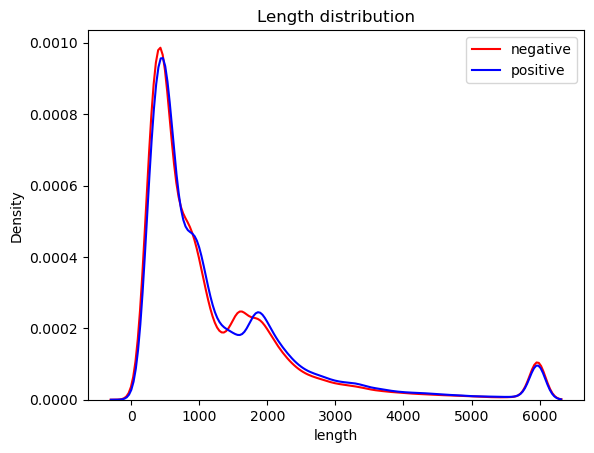

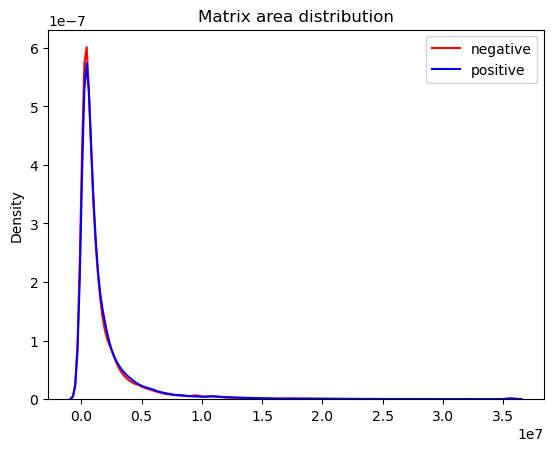

In [65]:
sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.legend()
plt.show()
sns.kdeplot(matrix_area_neg, color = 'red', label = 'negative')
sns.kdeplot(matrix_area_pos, color = 'blue', label = 'positive')
plt.title(f'Matrix area distribution')
plt.legend()
plt.show()

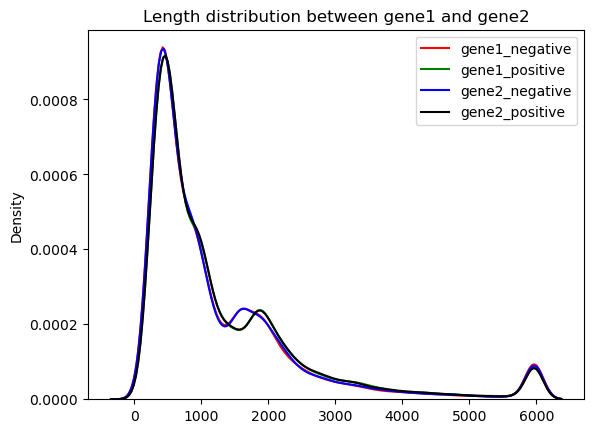

In [66]:
sns.kdeplot(neg_len_1, color = 'red', label = 'gene1_negative')
sns.kdeplot(pos_len_1, color = 'green', label = 'gene1_positive')
sns.kdeplot(neg_len_2, color = 'blue', label = 'gene2_negative')
sns.kdeplot(pos_len_2, color = 'black', label = 'gene2_positive')
plt.title(f'Length distribution between gene1 and gene2')
plt.legend()
plt.show()

In [67]:
small_l = df_len.length.quantile(0.1)
print(df_len[df_len['length'] < small_l].label.value_counts())
print('\n')
big_l = df_len.length.quantile(0.7)
print(df_len[df_len['length'] > big_l].label.value_counts())

n    14238
p    12490
Name: label, dtype: int64


p    44562
n    41295
Name: label, dtype: int64


In [6]:
dataset_train = RNADatasetNT(
    gene2info=df_genes_nt,
    interactions=df_nt,
    subset_file=subset_train_nt,
    augment_policies=policies_train,
    data_dir = os.path.join(embedding_dir, '32'),
)

all_couples = set(df_nt.couples_id)

augment_list = create_augment_list(dataset_train, all_couples)

dataset_train = HFDataset(augment_list)

batch_size = 32

sampler_train = torch.utils.data.RandomSampler(dataset_train)

data_loader_train = HFDataLoader(dataset_train, batch_size=batch_size, 
                                 sampler=sampler_train, drop_last=False,
                                 collate_fn = utils.collate_fn_hf, num_workers=10)

start_time = time.time()

i = 0
for s, targets in tqdm(data_loader_train):
    i += 1
    if i == 100:
        break
    
end_time = time.time()

print('min:', (end_time-start_time)/60)

  0%|          | 0/3696 [00:00<?, ?it/s]

min: 2.3028923869132996


In [ ]:
policies = [
    EasyPosAugment(
        per_sample=1,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=pos_multipliers,
        height_multipliers=pos_multipliers,
    ),  
    SmartNegAugment(
        per_sample=unbalance_factor,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=neg_multipliers,
        height_multipliers=neg_multipliers,
    ),
]
  

dataset_train = RNADatasetNT(
    gene2info=df_genes_nt,
    interactions=df_nt,
    subset_file=subset_train_nt,
    augment_policies=policies,
    data_dir = os.path.join(embedding_dir, '32'),
)

sampler_train = torch.utils.data.RandomSampler(dataset_train)

data_loader_train = DataLoader(dataset_train, 32,
                             sampler=sampler_train, drop_last=False,
                             collate_fn=utils.collate_fn_nt,
                             num_workers=2,)

start_time = time.time()

i = 0
for s, targets in tqdm(data_loader_train, total = len(data_loader_train)):
    i += 1
    if i == 100:
        break
    
end_time = time.time()

print('min:', (end_time-start_time)/60)

# Validation set 

In [48]:
subset_val_nt = os.path.join(rna_rna_files_dir, f"gene_pairs_val_sampled_nt.txt")
pos_multipliers = {25:0.7,
                   50:0.2, 
                   100:0.1}
neg_multipliers = pos_multipliers

policies_val = [
    EasyPosAugment(
        per_sample=1,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=pos_multipliers,
        height_multipliers=pos_multipliers,
    ),  
    SmartNegAugment(
        per_sample=1,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=neg_multipliers,
        height_multipliers=neg_multipliers,
    ),
]

dataset_val = RNADatasetNT(
    gene2info=df_genes_nt,
    interactions=df_nt,
    subset_file=subset_val_nt,
    augment_policies=policies_val,
    data_dir = os.path.join(embedding_dir, '32'),
)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/28392 [00:00<?, ?it/s]

median: 650.0


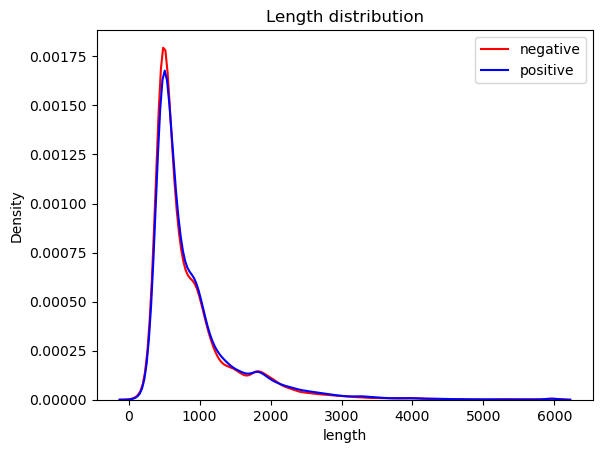

In [56]:
neg_len_1 = []
pos_len_1 = []
neg_len_2 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []

for epoch in tqdm(range(n_epochs)):
    for sample in tqdm(dataset_val, total=len(dataset_val)):
        box = sample.bbox
        if sample.interacting:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
        else:
            neg_len_1.append(box.x2-box.x1)
            neg_len_2.append(box.y2-box.y1)
            matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))
        
neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

print('median:', df_len.length.median())

sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.legend()

In [ ]:
g = torch.Generator()
g.manual_seed(0)
data_loader_val = DataLoader(dataset_val, 32,
                             sampler=sampler_val, drop_last=False,
                             collate_fn=utils.collate_fn_nt2,
                             num_workers=2,
                             worker_init_fn=seed_worker, 
                             generator=g,)

neg_len_1 = []
pos_len_1 = []
neg_len_2 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []

for s, targets in tqdm(data_loader_val, total = len(data_loader_val)):
    for sample in targets:
        box = sample['bbox']
        if sample['interacting']==1:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
        else:
            neg_len_1.append(box.x2-box.x1)
            neg_len_2.append(box.y2-box.y1)
            matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))
            
neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

In [ ]:
df_len.label.value_counts()

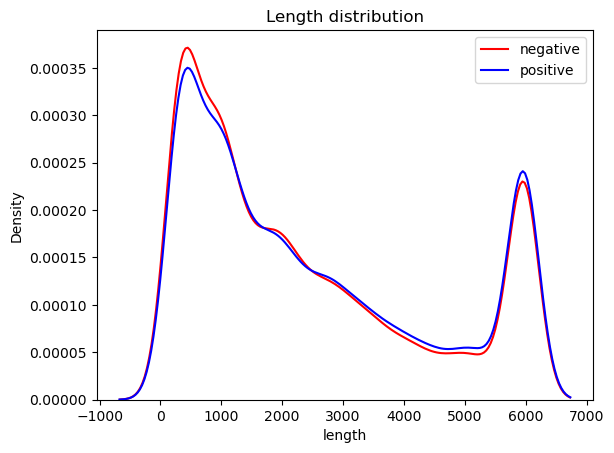

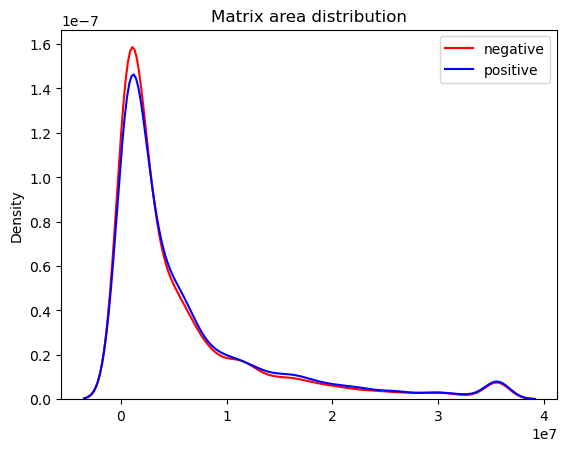

In [12]:
sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.legend()
plt.show()
sns.kdeplot(matrix_area_neg, color = 'red', label = 'negative')
sns.kdeplot(matrix_area_pos, color = 'blue', label = 'positive')
plt.title(f'Matrix area distribution')
plt.legend()
plt.show()

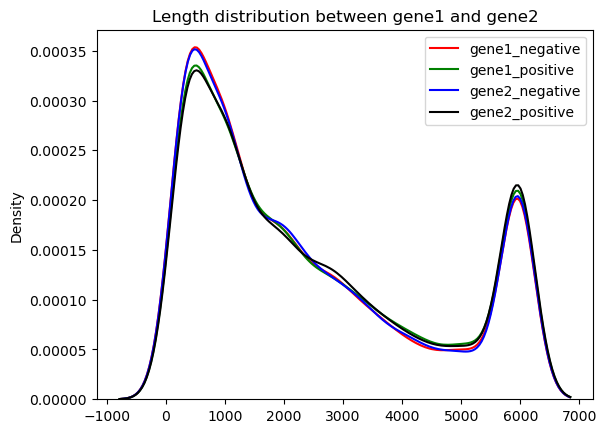

In [13]:
sns.kdeplot(neg_len_1, color = 'red', label = 'gene1_negative')
sns.kdeplot(pos_len_1, color = 'green', label = 'gene1_positive')
sns.kdeplot(neg_len_2, color = 'blue', label = 'gene2_negative')
sns.kdeplot(pos_len_2, color = 'black', label = 'gene2_positive')
plt.title(f'Length distribution between gene1 and gene2')
plt.legend()
plt.show()

# Test 

In [29]:
pos_width_multipliers_test = pos_width_multipliers
pos_height_multipliers_test = pos_width_multipliers_test

neg_width_windows_test = neg_width_windows
neg_height_windows_test = neg_width_windows_test

assert np.round(sum(pos_width_multipliers_test.values()), 4) == np.round(sum(neg_width_windows_test.values()), 4) == 1    


policies_test = [
        EasyPosAugment(
            per_sample=2,
            interaction_selection=InteractionSelectionPolicy.LARGEST,
            width_multipliers=pos_width_multipliers_val,
            height_multipliers=pos_height_multipliers_val,
        ),
        EasyNegAugment(
            per_sample=0.04,
            width_windows=neg_width_windows_val,
            height_windows=neg_height_windows_val,
        ),
        HardPosAugment(
            per_sample=0.1,
            interaction_selection=InteractionSelectionPolicy.RANDOM_ONE,
            min_width_overlap=0.3,
            min_height_overlap=0.3,
            width_multipliers=pos_width_multipliers_val,
            height_multipliers=pos_height_multipliers_val,
        ),
        HardNegAugment(
            per_sample=0.04,
            width_windows=neg_width_windows_val,
            height_windows=neg_height_windows_val,
        ),
        SmartNegAugment(
        per_sample=1,
        interaction_selection=InteractionSelectionPolicy.LARGEST,
        width_multipliers=pos_width_multipliers_val,
        height_multipliers=pos_height_multipliers_val,
    ),
]

dataset_test = RNADataset(
            gene2info=df_genes,
            interactions=df,
            subset_file=os.path.join(rna_rna_files_dir, f"gene_pairs_test.txt"),
            augment_policies=policies_test,
)
sampler_test = torch.utils.data.SequentialSampler(dataset_test)

In [30]:
g = torch.Generator()
g.manual_seed(0)
data_loader_test = DataLoader(dataset_test, 32,
                             sampler=sampler_test, drop_last=False,
                             collate_fn=utils.collate_fn,
                             num_workers=10,
                             worker_init_fn=seed_worker, 
                             generator=g,)

neg_len_1 = []
pos_len_1 = []
neg_len_2 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []

for s, targets in tqdm(data_loader_test, total = len(data_loader_test)):
    for sample in targets:
        box = sample['bbox']
        if sample['interacting']==1:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
        else:
            neg_len_1.append(box.x2-box.x1)
            neg_len_2.append(box.y2-box.y1)
            matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))
            
neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

  0%|          | 0/1463 [00:00<?, ?it/s]

In [31]:
df_len.label.value_counts()

n    46900
p    46688
Name: label, dtype: int64

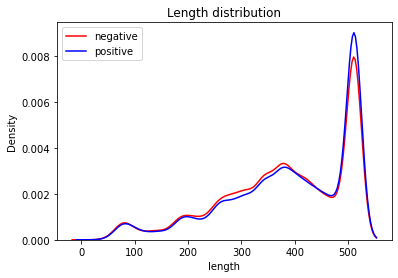

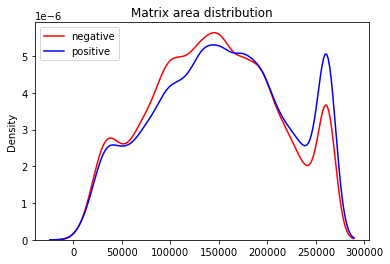

In [32]:
sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.legend()
plt.show()
sns.kdeplot(matrix_area_neg, color = 'red', label = 'negative')
sns.kdeplot(matrix_area_pos, color = 'blue', label = 'positive')
plt.title(f'Matrix area distribution')
plt.legend()
plt.show()